**Hello!**

This is just a simple example, using **Random Forest**, **MPL** and a little of **parameter tunning**  in the **Titanic dataset**.
Hope you enjoy it...

In [1]:
#First, the necessary tools:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:
#Reading the data
test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')

#Saving the PassengerID to the submission, since it's required...
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']

In [3]:
#inspecting the data:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [5]:
#Here I'm removing things that I think that wouldn't be useful
# (of course this is just a supposition, in fact, they are useful with proper use)
train.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace = True)
test.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace = True)

#Get_dummyes convert categorical variable into dummy/indicator variables
data_train = pd.get_dummies(train)
data_test = pd.get_dummies(test)

#"Filnna" fills empty values, I'm replacing they for the mean of the values.
# (but, again, there are better ways to do this... this is just an example)
data_train['Age'].fillna(data_train['Age'].mean(), inplace = True)
data_test['Age'].fillna(data_test['Age'].mean(), inplace = True)
data_test['Fare'].fillna(data_test['Fare'].mean(), inplace = True)

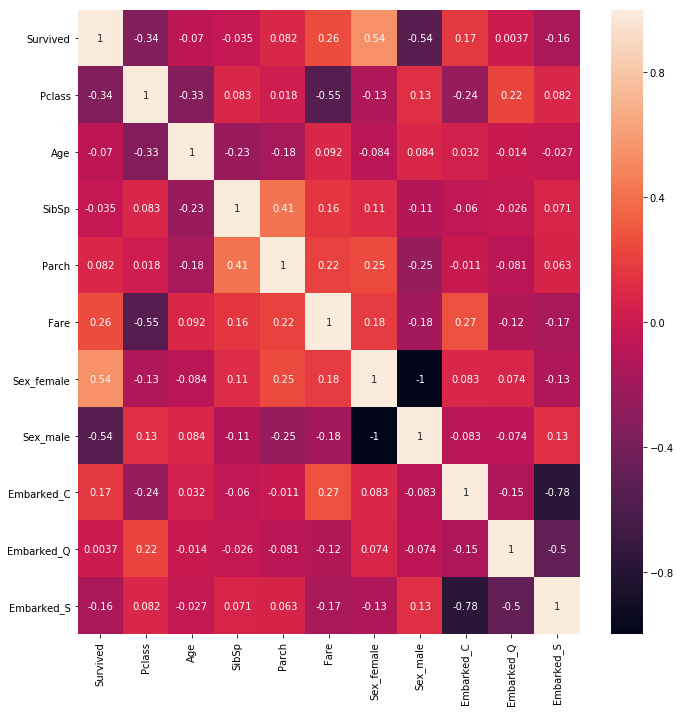

<Figure size 432x288 with 0 Axes>

In [6]:
# Calculate correlation matrix
corr = data_train.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

In [7]:
# Separating the data into variables to analyze (x) and the result (y) that we expect
x = data_train.drop('Survived', axis=1)
y = data_train['Survived']

In [8]:
# Parametrizing the method and testing using cross-validation
# You can change the parameters to get better results; ^^
classifier_rf = RandomForestClassifier(
                criterion='gini',
                max_depth=50,
                n_estimators=100,
                n_jobs=-1)
    
scores_rf = cross_val_score(classifier_rf, x, y, scoring='accuracy', cv=5)
print(scores_rf.mean())

0.8148683216143631


In [9]:
#this result is for the training... we want to know for tests, so:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
#Here we do some parameter optimization

from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [150, 100, 50], 'max_depth': [10, 25, 50], 'max_features': [4, 6, 8], 'random_state': [42], 'criterion': ['gini']}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    classifier_rf.set_params(**g)  # ** is "unpacking" the dictionary
    classifier_rf.fit(train_X, train_y)
    test_scores.append(classifier_rf.score(test_X, test_y))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.8379888268156425 {'random_state': 42, 'n_estimators': 50, 'max_features': 4, 'max_depth': 10, 'criterion': 'gini'}


In [11]:
#ok, let's fit the model with the best parameters in test

classifier_rf = RandomForestClassifier(
                criterion='gini',
                max_depth=10,
                max_features=4,
                n_estimators=50,
                random_state=42,
                n_jobs=-1)

# Training the model with the data
classifier_rf.fit(x, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
predictions = classifier_rf.predict(test_X)
print(confusion_matrix(test_y,predictions))
print(classification_report(test_y,predictions))

[[103   2]
 [  7  67]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       105
           1       0.97      0.91      0.94        74

   micro avg       0.95      0.95      0.95       179
   macro avg       0.95      0.94      0.95       179
weighted avg       0.95      0.95      0.95       179



# 95% that's impressive for a simple model.. :D

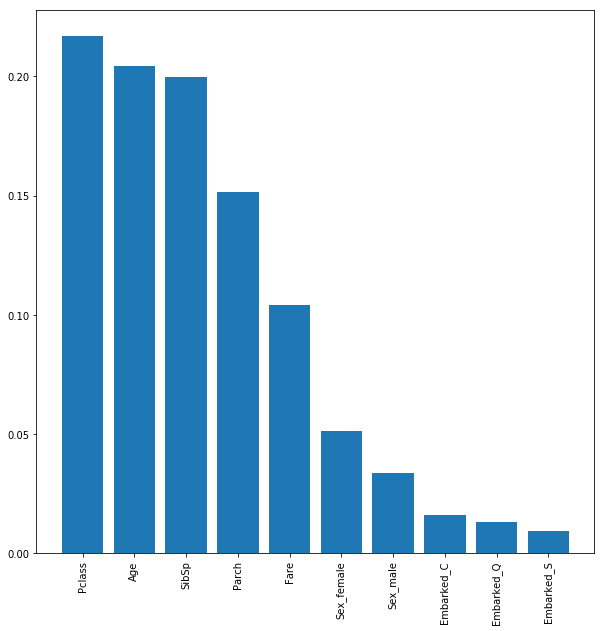

In [13]:
# Get feature importances from our random forest model
importances = classifier_rf.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
aux = range(len(importances))

# Create tick labels
labels = x.columns.values
plt.figure(figsize=(10,10))
plt.bar(aux, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

### Well, we have some unnecessary columns (like having two sex variables, where we only need one...)
### We should do some feature enginery, for sure

## Before our submission, let's try another model:

In [14]:
mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

mlp.fit(x,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [15]:
predictions = mlp.predict(test_X)
print(confusion_matrix(test_y,predictions))
print(classification_report(test_y,predictions))

[[91 14]
 [21 53]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

   micro avg       0.80      0.80      0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



# 80%, not so good (but remember that we skipped the parameter tuning)

In [16]:
# Creating a submission
submission['Survived'] = classifier_rf.predict(data_test)
submission.to_csv('submission.csv', index=False)

Now just go there and post your submission! ^^

**Thanks for reading and have a great day!**
